In [1]:
import glob
import os
import json
import numpy as np
import scipy.linalg as linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.lines import Line2D
import mne
from braindecode.datasets import BaseDataset, BaseConcatDataset, WindowsDataset
from braindecode.datautil.preprocess import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor,
)
from braindecode.datautil.windowers import create_windows_from_events
from tqdm import tqdm

In [2]:
data_dir = "/home/txdat/code/DataVIN/Official"

In [3]:
def load_subject_dirs(data_dir):
    out = list()
    for d in glob.glob(f"{data_dir}/*"):
        if os.path.exists(f"{d}/info.json"):
            out.append(d)
        elif os.path.isdir(d) and not os.path.exists(f"{d}/EEG.edf"):
            out.extend(load_subject_dirs(d))

    return out

In [4]:
raw = mne.io.read_raw_edf(
    f"{data_dir}/K344/sample1/EEG.edf", preload=True, verbose=False
)
raw.set_montage("standard_1005")

<RawEDF | EEG.edf, 32 x 17152 (134.0 s), ~4.2 MB, data loaded>

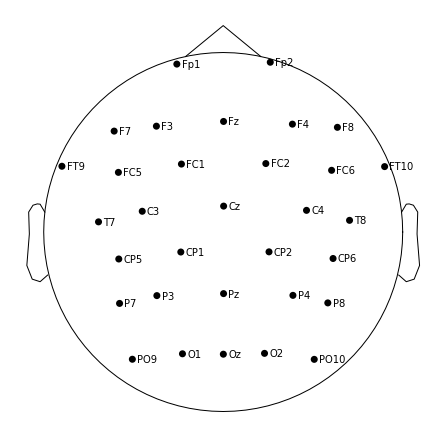

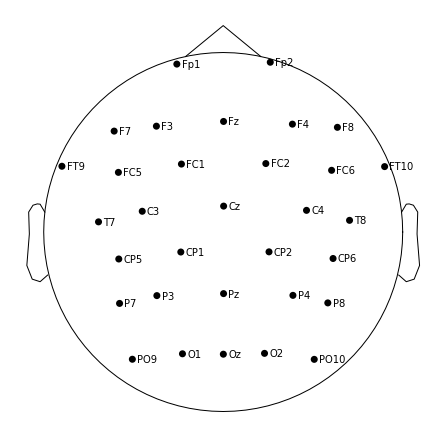

In [5]:
raw.plot_sensors(show_names=True)

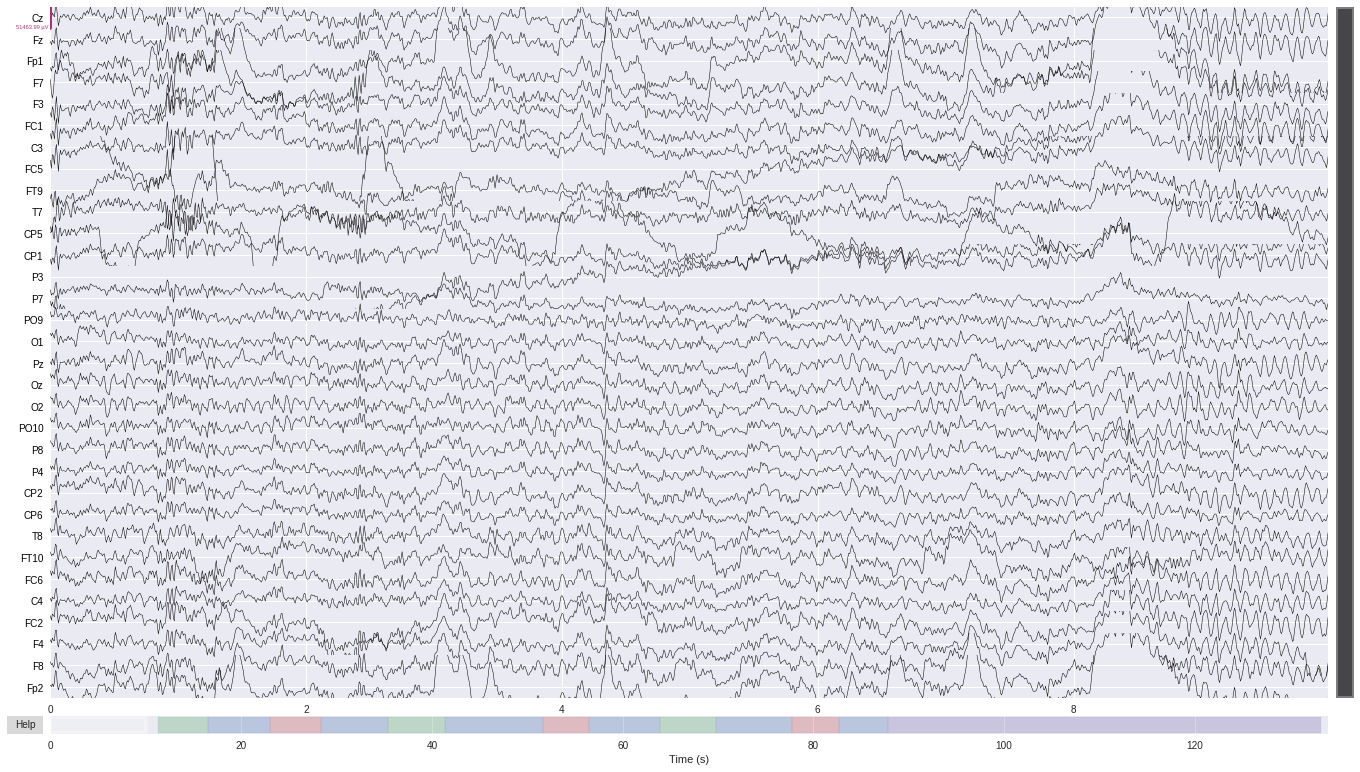

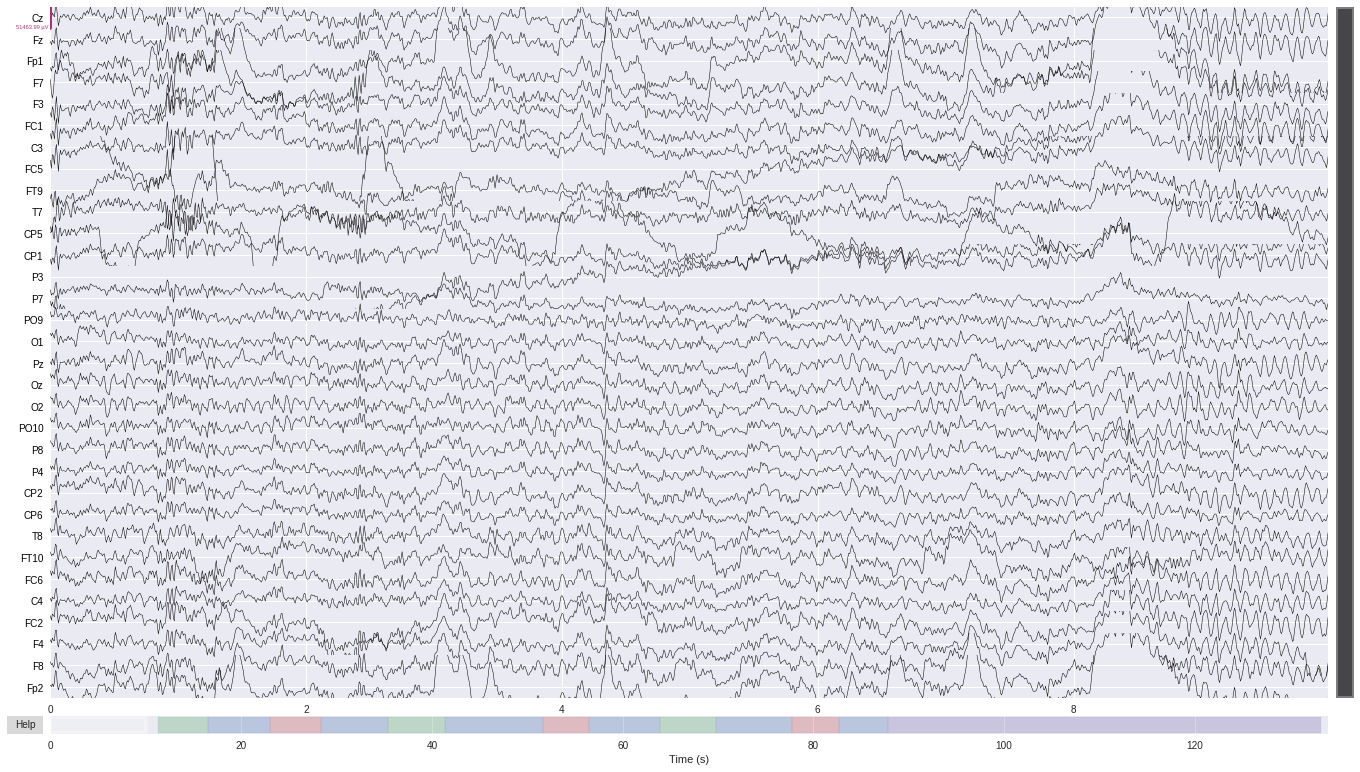

In [131]:
raw.plot(n_channels=32, scalings="auto")

In [132]:
raw.annotations.description

array(['Thinking', 'Resting', 'Thinking and Acting', 'Resting',
       'Thinking', 'Resting', 'Thinking and Acting', 'Resting',
       'Thinking', 'Resting', 'Thinking and Acting', 'Resting', 'Typing'],
      dtype='<U19')

In [133]:
raw = mne.io.read_raw_edf(
    f"{data_dir}/K344/sample9/EEG.edf", preload=True, verbose=False
)
raw.set_montage("standard_1005")

<RawEDF | EEG.edf, 32 x 12416 (97.0 s), ~3.1 MB, data loaded>

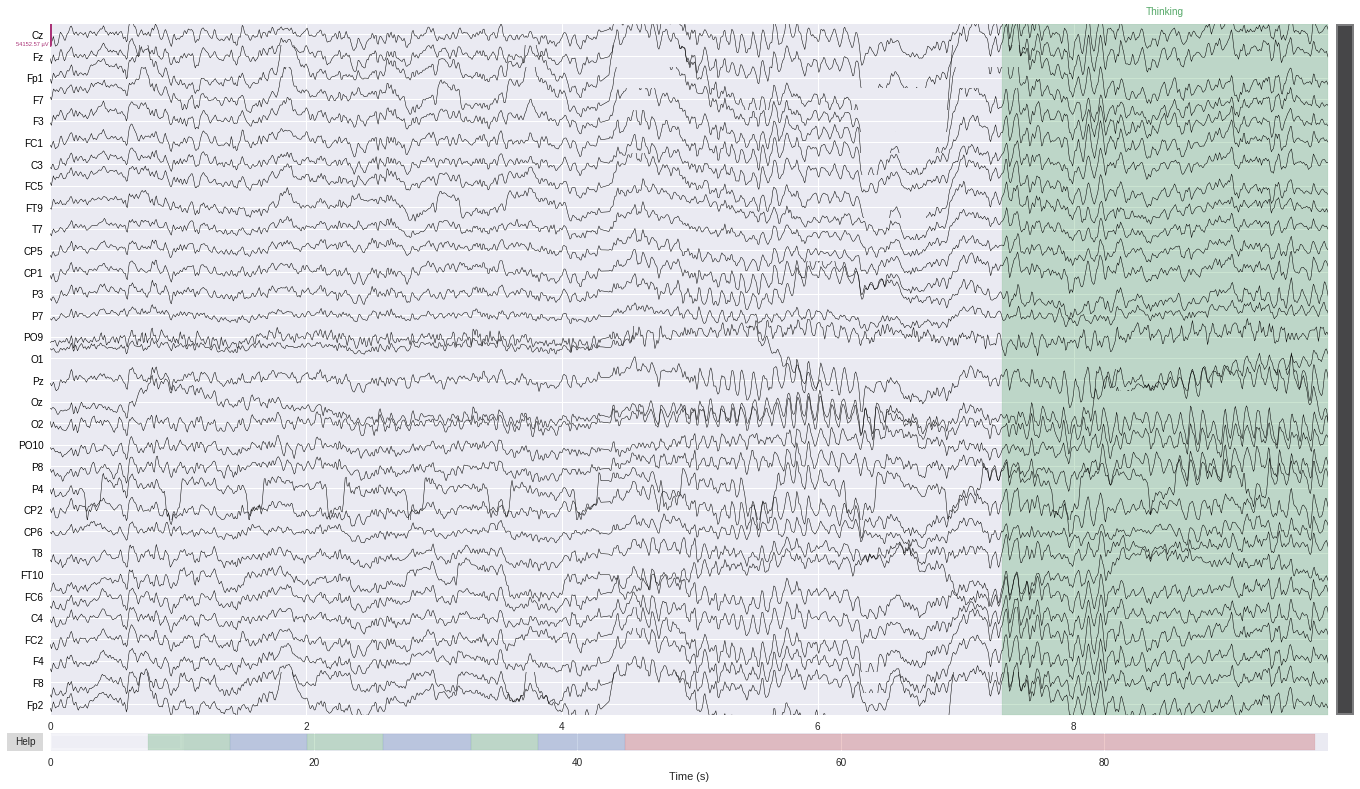

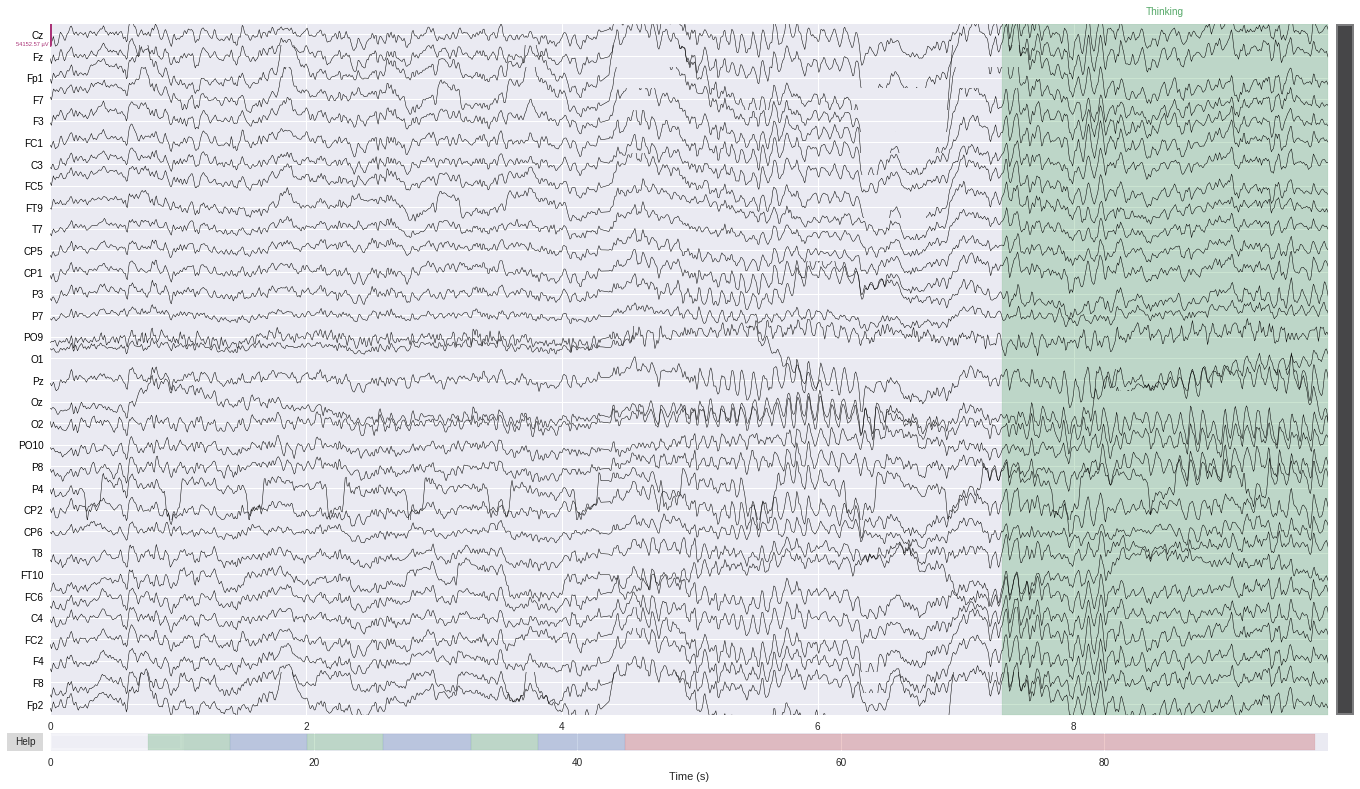

In [134]:
raw.plot(n_channels=32, scalings="auto")

In [135]:
raw.annotations.description

array(['Thinking', 'Resting', 'Thinking', 'Resting', 'Thinking',
       'Resting', 'Typing'], dtype='<U8')

In [19]:
def load_vin_data(
    data_dir,
    scenarios,
    train_subjects,
    valid_subjects,
    test_subjects,
    window_size,
    window_stride,
    events=None,
    channels=None,
    fmin=4.0,
    fmax=38.0,
    alignment=True,
):
    """
    load windowed trials from Official VIN dataset
    """

    scenarios = set(scenarios or list())

    train_subjects = set(train_subjects or list())
    valid_subjects = set(valid_subjects or list())
    test_subjects = set(test_subjects or list())
    subjects = train_subjects | valid_subjects | test_subjects

    # load raw datasets
    list_of_ds = list()
    for subject_dir in tqdm(glob.glob(f"{data_dir}/*"), desc="subject"):
        if not os.path.isdir(subject_dir) or not os.path.exists(
            f"{subject_dir}/info.json"
        ):
            continue

        subject_id = subject_dir.split("/")[-1]
        if len(subjects) > 0 and subject_id not in subjects:
            continue

        for sample_dir in glob.glob(f"{subject_dir}/sample*"):
            if (
                not os.path.isdir(sample_dir)
                or not os.path.exists(f"{sample_dir}/EEG.edf")
                or not os.path.exists(f"{sample_dir}/eeg.json")
            ):
                continue

            with open(f"{sample_dir}/eeg.json", mode="r") as f:
                scenario = json.load(f).get("Scenario", "").strip().lower()

            if len(scenarios) > 0 and scenario not in scenarios:
                continue

            raw = mne.io.read_raw_edf(
                f"{sample_dir}/EEG.edf", preload=True, verbose=False
            )
            raw.set_montage("standard_1005")

            # fix wrong annotation in some subjects
            if scenario in {"tôi muốn uống nước", "tôi muốn vệ sinh"}:
                raw.annotations.description[
                    np.where(raw.annotations.description == "Thinking and Acting")[0]
                ] = "Thinking"

            list_of_ds.append(
                BaseDataset(
                    raw, description={"subject": subject_id, "scenario": scenario}
                )
            )

    ds = BaseConcatDataset(list_of_ds)

    # preprocessing

    # init preprocessor
    preprocessors = [
        Preprocessor("pick_types", eeg=True, stim=False),  # Keep EEG sensors
        Preprocessor(
            "filter",
            l_freq=fmin,
            h_freq=fmax,
            n_jobs=-1,
            verbose=False,
        ),  # Bandpass filter
        Preprocessor(lambda x: x * 1e6),  # Convert from V to uV
        Preprocessor(
            exponential_moving_standardize,  # Exponential moving standardization
            factor_new=1e-3,
            init_block_size=1000,
        ),
    ]

    preprocess(ds, preprocessors)

    # create windows
    if events is not None:
        mapping = {event: _id for _id, event in enumerate(events)}
    else:
        mapping = {
            "Resting": 0,
            "Thinking": 1,
            "Thinking and Acting": 2,
        }  # skip "Typing"

    ds = create_windows_from_events(
        ds,
        trial_start_offset_samples=0,
        trial_stop_offset_samples=0,
        window_size_samples=window_size,
        window_stride_samples=window_stride,
        drop_last_window=True,
        mapping=mapping,
        preload=True,
        picks=channels,
        n_jobs=-1,
    )

    # change format to BNCI 2a dataset
    # https://braindecode.org/auto_examples/plot_bcic_iv_2a_moabb_cropped.html#sphx-glr-auto-examples-plot-bcic-iv-2a-moabb-cropped-py
    label_id = {"Resting": 0} if "Resting" in mapping else dict()
    for scenario in sorted(ds.description["scenario"].unique()):
        for event in sorted(mapping.keys()):
            if event == "Resting":
                continue
            if (
                scenario in {"tôi muốn uống nước", "tôi muốn vệ sinh"}
                and event == "Thinking and Acting"
            ):
                continue

            label_id[f"{scenario}_{event}"] = len(label_id)

    #     print(label_id)

    list_of_ds = list()
    for subject in tqdm(
        ds.description["subject"].unique(), desc="preprocessing subject"
    ):
        # join epochs and rebuild labels
        list_of_epochs = list()
        labels = list()
        for i, r in ds.description[ds.description["subject"] == subject].iterrows():
            epochs = ds.datasets[i].windows

            # TODO: resample epochs' data if neccessary

            #             print(epochs.metadata)
            #             print(epochs.event_id)
            #             print(epochs.events)

            #             assert np.array_equal(np.asarray(epochs.metadata["target"], dtype=int), epochs.events[:, -1])

            id_event = {_id: event for event, _id in epochs.event_id.items()}

            _labels = [id_event[_id] for _id in epochs.events[:, -1]]
            _labels = np.array(
                [
                    label_id[
                        f"{r['scenario']}_{lbl}" if lbl != "Resting" else "Resting"
                    ]
                    for lbl in _labels
                ],
                dtype=int,
            )

            list_of_epochs.append(epochs)
            labels.append(_labels)

        epochs = mne.concatenate_epochs(list_of_epochs)
        epochs.events[:, -1] = np.concatenate(labels, axis=0)
        epochs.event_id = label_id
        epochs.metadata["target"] = epochs.events[:, -1]

        if alignment:
            # TODO: euclidean alignment (using "Resting" epochs?)
            x = epochs.get_data()  # [N,C,T]
            R = np.mean(x @ x.transpose((0, 2, 1)), axis=0)  # [C,C]
            R = linalg.inv(linalg.sqrtm(R))
            if np.iscomplexobj(R):
                R = np.real(R).astype(np.float32)

            epochs.apply_function(
                lambda x: R @ x, channel_wise=False
            )  # apply all channels

        session = "train"
        if subject in valid_subjects:
            session = "valid"
        elif subject in test_subjects:
            session = "test"

        list_of_ds.append(
            WindowsDataset(
                windows=epochs, description={"subject": subject, "session": session}
            )
        )

    ds = BaseConcatDataset(list_of_ds)

    return ds

In [5]:
scenarios = ["nâng tay trái", "nâng tay phải", "nâng chân trái", "nâng chân phải"]

train_subjects = [f"K{d}" for d in range(299, 336)]
valid_subjects = [f"K{d}" for d in range(336, 345)]
test_subjects = []

events = ["Thinking"]

channels = [
    # "Fp1", "Fp2",
    "F7",
    "F3",
    "Fz",
    "F4",
    "F8",
    "FC5",
    "FC1",
    "FC2",
    "FC6",
    "T7",
    "C3",
    "Cz",
    "C4",
    "T8",
    "CP5",
    "CP1",
    "CP2",
    "CP6",
    "P7",
    "P3",
    "Pz",
    "P4",
    "P8",
    # "O1", "Oz", "O2",
]

print(f"using {len(channels)} channels")

window_size = 384
window_stride = 16

fmin = 8.0
fmax = 30.0

alignment = True

using 23 channels


In [9]:
ds = load_vin_data(
    data_dir,
    scenarios=scenarios,
    train_subjects=train_subjects,
    valid_subjects=valid_subjects,
    test_subjects=[],
    window_size=window_size,
    window_stride=window_stride,
    events=events,
    channels=channels,
    fmin=fmin,
    fmax=fmax,
    alignment=alignment,
)

df = ds.description.copy()
df["trials"] = [len(_ds.windows) for _ds in ds.datasets]
df.sort_values(["session", "subject"])

subject:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉             | 38/43 [00:03<00:00, 13.21it/s]/tmp/ipykernel_33573/1586542491.py:33: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=True, verbose=False)
subject: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00, 12.93it/s]


Used Annotations descriptions: ['Thinking']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
98 matching events found
No baseline correction applied
0 projection items activated
Loading data for 98 events and 384 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Thinking']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
102 matching events found
No baseline correction applied
0 projection items activated
Loading data for 102 events and 384 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Thinking']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
96 matching events found
No baseline correction applied
0 projection items activated
Loading data for 96 events and 384 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Thinking']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
80 matching events found
Use

preprocessing subject:   0%|                                                                                                           | 0/39 [00:00<?, ?it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
419 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:   3%|██▌                                                                                                | 1/39 [00:00<00:03,  9.80it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
366 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:   5%|█████                                                                                              | 2/39 [00:00<00:03,  9.50it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
414 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
346 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  10%|██████████▏                                                                                        | 4/39 [00:00<00:03, 10.79it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
303 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
391 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  15%|███████████████▏                                                                                   | 6/39 [00:00<00:03, 10.75it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
403 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
361 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  21%|████████████████████▎                                                                              | 8/39 [00:00<00:02, 11.08it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
507 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
323 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  26%|█████████████████████████▏                                                                        | 10/39 [00:01<00:03,  9.37it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
378 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  28%|███████████████████████████▋                                                                      | 11/39 [00:01<00:03,  8.61it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
425 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  31%|██████████████████████████████▏                                                                   | 12/39 [00:01<00:03,  8.43it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
371 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  33%|████████████████████████████████▋                                                                 | 13/39 [00:01<00:03,  8.30it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
307 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
343 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  38%|█████████████████████████████████████▋                                                            | 15/39 [00:01<00:02,  9.60it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
269 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
358 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  44%|██████████████████████████████████████████▋                                                       | 17/39 [00:01<00:02,  9.90it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
438 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  46%|█████████████████████████████████████████████▏                                                    | 18/39 [00:01<00:02,  9.52it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
447 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  49%|███████████████████████████████████████████████▋                                                  | 19/39 [00:02<00:02,  9.07it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
414 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  51%|██████████████████████████████████████████████████▎                                               | 20/39 [00:02<00:02,  9.19it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
335 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  54%|████████████████████████████████████████████████████▊                                             | 21/39 [00:02<00:01,  9.33it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
303 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
321 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  59%|█████████████████████████████████████████████████████████▊                                        | 23/39 [00:02<00:01,  9.46it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
497 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  62%|████████████████████████████████████████████████████████████▎                                     | 24/39 [00:02<00:01,  9.12it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
489 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  64%|██████████████████████████████████████████████████████████████▊                                   | 25/39 [00:02<00:01,  8.83it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
310 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
309 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  69%|███████████████████████████████████████████████████████████████████▊                              | 27/39 [00:02<00:01,  9.60it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
404 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  72%|██████████████████████████████████████████████████████████████████████▎                           | 28/39 [00:02<00:01,  9.53it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
306 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
363 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  77%|███████████████████████████████████████████████████████████████████████████▍                      | 30/39 [00:03<00:00,  9.73it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
479 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  79%|█████████████████████████████████████████████████████████████████████████████▉                    | 31/39 [00:03<00:00,  9.11it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
418 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 32/39 [00:03<00:00,  8.74it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
283 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
324 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 34/39 [00:03<00:00,  9.89it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
296 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
455 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 36/39 [00:03<00:00,  9.92it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
302 matching events found
No baseline correction applied
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
345 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 38/39 [00:03<00:00, 10.29it/s]

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
303 matching events found
No baseline correction applied
0 bad epochs dropped


preprocessing subject: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.61it/s]


subject session  trials
38    K299   train     303
27    K300   train     404
4     K301   train     303
31    K302   train     418
22    K303   train     321
24    K304   train     489
7     K305   train     361
5     K306   train     391
29    K307   train     363
16    K308   train     358
14    K309   train     343
2     K310   train     414
0     K311   train     419
23    K312   train     497
8     K313   train     507
12    K314   train     371
35    K315   train     455
19    K316   train     414
34    K318   train     296
25    K319   train     310
13    K320   train     307
37    K321   train     345
28    K322   train     306
21    K323   train     303
1     K324   train     366
10    K325   train     378
17    K326   train     438
11    K327   train     425
6     K328   train     403
20    K329   train     335
26    K330   train     309
3     K331   train     346
33    K332   train     324
9     K333   train     323
30    K334   train     479
18    K335   train     447
32    K342   valid     283
15    K343   valid     269
36    K344   valid     302

In [18]:
ds.datasets[0].windows.metadata[:50]

i_window_in_trial  i_start_in_trial  i_stop_in_trial  target
0                   0              1096             1480       2
1                   1              1112             1496       2
2                   2              1128             1512       2
3                   3              1144             1528       2
4                   4              1160             1544       2
5                   5              1176             1560       2
6                   6              1192             1576       2
7                   7              1208             1592       2
8                   8              1224             1608       2
9                   9              1240             1624       2
10                 10              1256             1640       2
11                 11              1272             1656       2
12                 12              1288             1672       2
13                 13              1304             1688       2
14                 14              1320             1704       2
15                 15              1336             1720       2
16                 16              1352             1736       2
17                 17              1368             1752       2
18                 18              1384             1768       2
19                 19              1400             1784       2
20                 20              1416             1800       2
21                 21              1432             1816       2
22                 22              1448             1832       2
23                 23              1464             1848       2
24                 24              1480             1864       2
25                 25              1496             1880       2
26                 26              1512             1896       2
27                 27              1528             1912       2
28                 28              1544             1928       2
29                 29              1560             1944       2
30                 30              1576             1960       2
31                 31              1592             1976       2
32                 32              1608             1992       2
33                  0              4862             5246       2
34                  1              4878             5262       2
35                  2              4894             5278       2
36                  3              4910             5294       2
37                  4              4926             5310       2
38                  5              4942             5326       2
39                  6              4958             5342       2
40                  7              4974             5358       2
41                  8              4990             5374       2
42                  9              5006             5390       2
43                 10              5022             5406       2
44                 11              5038             5422       2
45                 12              5054             5438       2
46                 13              5070             5454       2
47                 14              5086             5470       2
48                 15              5102             5486       2
49                 16              5118             5502       2

In [82]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pytorch_metric_learning.losses import ArcFaceLoss
from braindecode.util import set_random_seeds
from braindecode.models import EEGNetv4, Deep4Net
from braindecode import EEGClassifier
from braindecode.training.losses import CroppedLoss
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from skorch.setter import optimizer_setter
from skorch.dataset import unpack_data
from skorch.utils import to_tensor
from sklearn.metrics import confusion_matrix, classification_report
from braindecode.models.util import to_dense_prediction_model, get_output_shape
from functools import partial

In [21]:
set_random_seeds(seed=999, cuda=False)

In [83]:
def init_block(block: nn.Module):
    for m in block.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity="leaky_relu")

            if getattr(m, "bias", None) is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


class DilatedInceptionBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        dil_channels,
        base_kernel_size,
        stride=1,
        dil_scales=1,
        drop=0.25,
    ):
        super().__init__()

        self.dil_blocks = nn.ModuleList()
        for i in range(dil_scales):
            dil = 2 ** i
            self.dil_blocks.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        dil_channels,
                        kernel_size=(1, base_kernel_size),
                        stride=(1, stride),
                        padding=(0, base_kernel_size // 2 * dil),
                        dilation=(1, dil),
                        bias=False,
                    ),
                    nn.BatchNorm2d(dil_channels),
                    nn.LeakyReLU(inplace=True),
                    nn.Dropout(p=drop),
                )
            )

        self.merge_block = nn.Sequential(
            nn.Conv2d(
                dil_channels * dil_scales,
                out_channels,
                kernel_size=(1, 1),
                stride=(1, 1),
                padding=(0, 0),
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

        self.identity_block = (
            nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=(1, 1),
                    stride=(1, stride),
                    padding=(0, 0),
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(p=drop),
            )
            if in_channels != out_channels or stride > 1
            else nn.Identity()
        )

        # init params
        for block in self.dil_blocks:
            init_block(block)

        init_block(self.merge_block)

        init_block(self.identity_block)

    def forward(self, x: torch.Tensor):
        x0 = self.identity_block(x)

        x = torch.cat([block(x) for block in self.dil_blocks], dim=1)
        x = self.merge_block(x)

        x = x + x0

        return x


class DilatedInceptionNet(nn.Module):
    def __init__(
        self, n_classes, n_channels, n_samples, sfreq, embedding_size=64, drop=0.25
    ):
        super().__init__()

        # self.spatial_block = nn.Sequential(
        #     nn.Conv2d(
        #         1,
        #         8,
        #         kernel_size=(1, sfreq // 4 + 1 - (sfreq // 4) % 2),
        #         stride=(1, 4),
        #         padding=(0, sfreq // 8),
        #         bias=False,
        #     ),
        #     nn.BatchNorm2d(8),
        #     nn.Conv2d(
        #         8,
        #         16,
        #         kernel_size=(n_channels, 1),
        #         stride=(1, 1),
        #         padding=(0, 0),
        #         bias=False,
        #     ),
        #     nn.BatchNorm2d(16),
        #     nn.LeakyReLU(inplace=True),
        #     nn.Dropout(p=drop),
        # )

        self.temporal_block = nn.Sequential()
        in_channels = n_channels
        for i in range(1, 7, 2):
            k = sfreq // (2 ** i)
            self.temporal_block.add_module(
                f"dilated_block_{2 ** i}",
                nn.Sequential(
                    DilatedInceptionBlock(
                        in_channels,
                        16,
                        8,
                        base_kernel_size=k + 1 - k % 2,
                        stride=4,
                        dil_scales=3,
                        drop=drop,
                    ),
                    nn.Dropout(p=drop),
                ),
            )

            in_channels = 16

        with torch.no_grad():
            # x = torch.rand(1, 1, n_channels, n_samples).float()
            # x = self.spatial_block(x)
            x = torch.rand(1, n_channels, 1, n_samples).float()
            x = self.temporal_block(x)

            last_conv_kernel_size = x.size(3)  # [NC1T]

        self.last_conv_block = nn.Sequential(
            nn.Conv2d(
                16,
                embedding_size,
                kernel_size=(1, last_conv_kernel_size),
                stride=(1, 1),
                padding=(0, 0),
                bias=False,
            ),
            nn.BatchNorm2d(embedding_size),
        )

        self.pool = nn.Flatten()

        self.linear = nn.Sequential(
            nn.Linear(embedding_size, 32, bias=False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(inplace=True),
            nn.Linear(32, n_classes, bias=True),
            nn.LogSoftmax(dim=1),
        )

        # init params
        # init_block(self.spatial_block)
        init_block(self.temporal_block)
        init_block(self.last_conv_block)
        init_block(self.linear)

    def forward(self, x: torch.Tensor):
        # x = x.unsqueeze(1)  # [B,1,C,T]
        # x = self.spatial_block(x)
        x = x.unsqueeze(2)  # [B,C,1,T]
        x = self.temporal_block(x)
        x = self.last_conv_block(x)
        e = self.pool(x)
        x = self.linear(e)

        return x, e

In [84]:
model = DilatedInceptionNet(
    n_classes=4, n_channels=len(channels), n_samples=window_size, sfreq=128, drop=0.25
)

model

DilatedInceptionNet(
  (temporal_block): Sequential(
    (dilated_block_2): Sequential(
      (0): DilatedInceptionBlock(
        (dil_blocks): ModuleList(
          (0): Sequential(
            (0): Conv2d(23, 8, kernel_size=(1, 65), stride=(1, 4), padding=(0, 32), bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
            (3): Dropout(p=0.25, inplace=False)
          )
          (1): Sequential(
            (0): Conv2d(23, 8, kernel_size=(1, 65), stride=(1, 4), padding=(0, 64), dilation=(1, 2), bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
            (3): Dropout(p=0.25, inplace=False)
          )
          (2): Sequential(
            (0): Conv2d(23, 8, kernel_size=(1, 65), stride=(1, 4), padding=(0, 128), dilation=(1, 4), bias=False)
    

In [87]:
# to_dense_prediction_model(model)

In [24]:
get_output_shape(model, in_chans=len(channels), input_window_samples=window_size)

torch.Size([1, 4])

In [85]:
splitted = ds.split("session")
train_set = splitted["train"]
valid_set = splitted["valid"]

In [86]:
len(train_set), len(valid_set)

(13571, 854)

In [87]:
class MetricLoss(nn.Module):
    def __init__(
        self,
        n_classes,
        embedding_size,
        loss_function,
        weight=None,
        margin=0.5,
        scale=64,
        metric_factor=0.1,
    ):
        super().__init__()

        self.metric_loss = ArcFaceLoss(
            num_classes=n_classes,
            embedding_size=embedding_size,
            margin=margin * 180.0 / math.pi,
            scale=scale,
        )
        self.metric_factor = metric_factor

        self.loss_function = loss_function
        self.weight = weight

    def forward(self, input, embed, target):
        return (1.0 - self.metric_factor) * self.loss_function(
            input, target, weight=self.weight
        ) + self.metric_factor * self.metric_loss(embed, target)


class MetricEEGClassifier(EEGClassifier):
    def initialize_optimizer(self, triggered_directly=True):
        """Initialize the model optimizer. If ``self.optimizer__lr``
        is not set, use ``self.lr`` instead.

        Parameters
        ----------
        triggered_directly : bool (default=True)
          Only relevant when optimizer is re-initialized.
          Initialization of the optimizer can be triggered directly
          (e.g. when lr was changed) or indirectly (e.g. when the
          module was re-initialized). If and only if the former
          happens, the user should receive a message informing them
          about the parameters that caused the re-initialization.

        """
        args, kwargs = self.get_params_for_optimizer(
            "optimizer",
            list(self.module_.named_parameters())
            + list(self.criterion_.named_parameters()),
        )

        if self.initialized_ and self.verbose:
            msg = self._format_reinit_msg(
                "optimizer", kwargs, triggered_directly=triggered_directly
            )
            print(msg)

        if "lr" not in kwargs:
            kwargs["lr"] = self.lr

        self.optimizer_ = self.optimizer(*args, **kwargs)

        self._register_virtual_param(
            ["optimizer__param_groups__*__*", "optimizer__*", "lr"],
            optimizer_setter,
        )

    def get_loss(self, y_pred, embed, y_true, X=None, training=False):
        """Return the loss for this batch.

        Parameters
        ----------
        y_pred : torch tensor
          Predicted target values

        embed : torch tensor
          Embedding of input

        y_true : torch tensor
          True target values.

        X : input data, compatible with skorch.dataset.Dataset
          By default, you should be able to pass:

            * numpy arrays
            * torch tensors
            * pandas DataFrame or Series
            * scipy sparse CSR matrices
            * a dictionary of the former three
            * a list/tuple of the former three
            * a Dataset

          If this doesn't work with your data, you have to pass a
          ``Dataset`` that can deal with the data.

        training : bool (default=False)
          Whether train mode should be used or not.

        """
        y_true = to_tensor(y_true, device=self.device)

        if isinstance(self.criterion_, torch.nn.Module):
            self.criterion_.train(training)

        return self.criterion_(y_pred, embed, y_true)

    def validation_step(self, batch, **fit_params):
        """Perform a forward step using batched data and return the
        resulting loss.

        The module is set to be in evaluation mode (e.g. dropout is
        not applied).

        Parameters
        ----------
        batch
          A single batch returned by the data loader.

        **fit_params : dict
          Additional parameters passed to the ``forward`` method of
          the module and to the ``self.train_split`` call.

        """
        self._set_training(False)
        Xi, yi = unpack_data(batch)
        with torch.no_grad():
            y_pred, embed = self.infer(Xi, **fit_params)
            loss = self.get_loss(y_pred, embed, yi, X=Xi, training=False)
        return {
            "loss": loss,
            "y_pred": y_pred,
        }

    def train_step_single(self, batch, **fit_params):
        """Compute y_pred, loss value, and update net's gradients.

        The module is set to be in train mode (e.g. dropout is
        applied).

        Parameters
        ----------
        batch
          A single batch returned by the data loader.

        **fit_params : dict
          Additional parameters passed to the ``forward`` method of
          the module and to the ``self.train_split`` call.

        Returns
        -------
        step : dict
          A dictionary ``{'loss': loss, 'y_pred': y_pred}``, where the
          float ``loss`` is the result of the loss function and
          ``y_pred`` the prediction generated by the PyTorch module.

        """
        self._set_training(True)
        Xi, yi = unpack_data(batch)
        y_pred, embed = self.infer(Xi, **fit_params)
        loss = self.get_loss(y_pred, embed, yi, X=Xi, training=True)
        loss.backward()
        return {
            "loss": loss,
            "y_pred": y_pred,
        }

    def evaluation_step(self, batch, training=False):
        """Perform a forward step to produce the output used for
        prediction and scoring.

        Therefore, the module is set to evaluation mode by default
        beforehand which can be overridden to re-enable features
        like dropout by setting ``training=True``.

        Parameters
        ----------
        batch
          A single batch returned by the data loader.

        training : bool (default=False)
          Whether to set the module to train mode or not.

        Returns
        -------
        y_infer
          The prediction generated by the module.

        """
        self.check_is_fitted()
        Xi, _ = unpack_data(batch)
        with torch.set_grad_enabled(training):
            self._set_training(training)
            y_pred, _ = self.infer(Xi)

            return y_pred

In [88]:
clf = MetricEEGClassifier(
    model,
    cropped=False,
    criterion=MetricLoss,
    criterion__loss_function=F.nll_loss,
    criterion__weight=None,
    criterion__n_classes=4,
    criterion__embedding_size=64,
    optimizer=optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=1e-2,
    optimizer__weight_decay=5e-5,
    iterator_train__shuffle=True,
    batch_size=128,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=300)),
    ],
    device=torch.device("cpu"),
)

In [89]:
clf.initialize()

<class '__main__.MetricEEGClassifier'>[initialized](
  module_=DilatedInceptionNet(
    (temporal_block): Sequential(
      (dilated_block_2): Sequential(
        (0): DilatedInceptionBlock(
          (dil_blocks): ModuleList(
            (0): Sequential(
              (0): Conv2d(23, 8, kernel_size=(1, 65), stride=(1, 4), padding=(0, 32), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
              (3): Dropout(p=0.25, inplace=False)
            )
            (1): Sequential(
              (0): Conv2d(23, 8, kernel_size=(1, 65), stride=(1, 4), padding=(0, 64), dilation=(1, 2), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): LeakyReLU(negative_slope=0.01, inplace=True)
              (3): Dropout(p=0.25, inplace=False)
            )
            (2): Sequential(
              (0): Co

In [90]:
for X, y, i in clf.get_iterator(train_set, training=True, drop_index=False):
    #     print(X.size())
    #     print(y.size())
    i = np.hstack([ii.cpu().numpy()[:, np.newaxis] for ii in i])
    print(i)
    break

[[    3  7451  7835]
 [    2  1002  1386]
 [   24  7065  7449]
 [   18  8113  8497]
 [   25  1358  1742]
 [   17  8311  8695]
 [   24  1452  1836]
 [    4  5455  5839]
 [    8  7238  7622]
 [    8  4689  5073]
 [   13  9703 10087]
 [   10  4721  5105]
 [   16  1786  2170]
 [    6  2198  2582]
 [    8  1151  1535]
 [   19  9071  9455]
 [   30  7800  8184]
 [   13  6721  7105]
 [   20  3533  3917]
 [   13  7164  7548]
 [   15  6597  6981]
 [   20   705  1089]
 [    8  2126  2510]
 [    0  3789  4173]
 [   16  1690  2074]
 [    9  7254  7638]
 [   24  8672  9056]
 [   30  8704  9088]
 [   14  6636  7020]
 [   14  8895  9279]
 [   16  4424  4808]
 [   17  4169  4553]
 [    9  1468  1852]
 [   21  4854  5238]
 [   10  5186  5570]
 [   47  5321  5705]
 [   15  7409  7793]
 [   11   929  1313]
 [   38  8464  8848]
 [   18  8512  8896]
 [    6  8135  8519]
 [   17  3657  4041]
 [   13  5885  6269]
 [   40  1921  2305]
 [   22  1401  1785]
 [   25  1568  1952]
 [    2 10402 10786]
 [   14  5595

In [111]:
clf.fit(train_set, y=None, epochs=300)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2455        1.4290            0.2652        1.3859  0.0010  7.7129
      2            0.2455        1.3956            0.2652        1.3900  0.0010  8.4805
      3            0.2464        1.3784            0.2634        1.3956  0.0010  9.8883
      4            0.2921        1.3452            0.2565        1.3761  0.0010  9.9851
      5            0.4234        1.2972            0.3397        1.3143  0.0010  11.5421
      6            0.4879        1.2521            0.3813        1.2804  0.0010  11.8751
      7            0.4980        1.2040            0.3830        1.2849  0.0010  9.7155
      8            0.5464        1.1557            0.3882        1.2837  0.0010  9.3946
      9            0.5660        1.1246            0.3674        1.2991  0.0009  9.7967
     10            0.5937     

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=EEGNetv4(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=_transpose_to_b_1_c_0) 
    (conv_temporal): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (bnorm_temporal): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv_spatial): Conv2dWithConstraint(8, 16, kernel_size=(26, 1), stride=(1, 1), groups=8, bias=False)
    (bnorm_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (elu_1): Expression(expression=elu) 
    (pool_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (drop_1): Dropout(p=0.4, inplace=False)
    (conv_separable_depth): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (conv_separable_point): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bnorm_2): BatchNorm2d(16, eps=0.001, momentum=0.01, aff

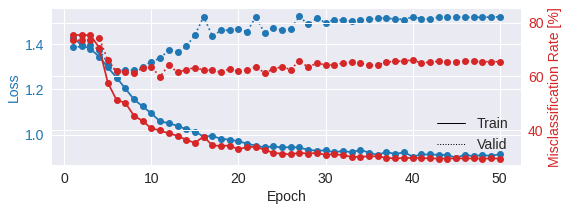

In [112]:
# Extract loss and accuracy values for plotting from history object
results_columns = ["train_loss", "valid_loss", "train_accuracy", "valid_accuracy"]
df = pd.DataFrame(
    clf.history[:, results_columns],
    columns=results_columns,
    index=clf.history[:, "epoch"],
)

# get percent of misclass for better visual comparison to loss
df = df.assign(
    train_misclass=100 - 100 * df.train_accuracy,
    valid_misclass=100 - 100 * df.valid_accuracy,
)

plt.style.use("seaborn")
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ["train_loss", "valid_loss"]].plot(
    ax=ax1, style=["-", ":"], marker="o", color="tab:blue", legend=False, fontsize=14
)

ax1.tick_params(axis="y", labelcolor="tab:blue", labelsize=14)
ax1.set_ylabel("Loss", color="tab:blue", fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ["train_misclass", "valid_misclass"]].plot(
    ax=ax2, style=["-", ":"], marker="o", color="tab:red", legend=False
)
ax2.tick_params(axis="y", labelcolor="tab:red", labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color="tab:red", fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(
    Line2D([0], [0], color="black", linewidth=1, linestyle="-", label="Train")
)
handles.append(
    Line2D([0], [0], color="black", linewidth=1, linestyle=":", label="Valid")
)
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()